In [1]:
import sys
sys.path.append("../")

from config import load_config
from train import Trainer

import numpy as np
import matplotlib.pyplot as plt
from config import FilterConfig, DataConfig
from nn.net import Net, ResNet, NetConfig
from data.plot_light_curve import plot_curves

import torch

c:\Users\luk\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_cfg = DataConfig(
    path="C:/Users/luk/Desktop/kyselica/classification_of_light_curves/resources/Fall_2021_2",
    labels=["cz-3", "titan", "falcon_9", "atlas_5", "h-2a", "globalstar"])

filter_cfg = FilterConfig(
    n_bins=30,
    n_gaps=2, 
    gap_size=0, 
    rms_ratio= 0,
    non_zero_ratio=0.2
)
net_cfg = NetConfig(
  name = "Net_6Classes_S",
  checkpoint = None,
  input_size = 300,
  n_channels = 10,
  n_classes = 6,
  hid_dim = 128,
  stride = 2,
  kernel_size = 5
)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# net = ResNet(net_cfg.n_classes, device=device, name=net_cfg.name)
net = Net(net_cfg)
net.load("latest")

cuda:0


In [4]:

# trainer = Trainer(net, data_cfg=data_cfg, filter_cfg=filter_cfg, sampler=False)
trainer = Trainer(net)

DATA_PATH = "C:/Users/luk/Desktop/kyselica/classification_of_light_curves/resources/6classes"
trainer.load_data_from_file(DATA_PATH)
# trainer.add_sampler()

In [5]:
net.load("latest")
trainer.net = net

In [16]:
trainer.train(400, print_on=False, save_interval=20, tensorboard_on=True)

In [6]:

trainer.evaluate(data_cfg.labels)

0 cz-3
1 titan
2 falcon_9
3 atlas_5
4 h-2a
5 globalstar
Train:
	Loss: 0.0026758485907206176
	Acc: 89.19309597150281
Validation:
	Loss: 0.003119342993435803
	Acc: 88.82690221602356
-----------------------------------------

        Label  cz-3  titan  falcon_9  atlas_5  h-2a  globalstar
0        cz-3  1733     15       159      129    63          20
1       titan     2    256         0        1     0           4
2    falcon_9     3      0       194        0     0           0
3     atlas_5    29      8         6      815    24           7
4        h-2a     3      0         0        2   247           0
5  globalstar    53     26         9       67    91        2487

-----------------------------------------

                cz-3      titan   falcon_9    atlas_5       h-2a  globalstar
Precision  81.783860  97.338403  98.477157  91.676040  98.015873   90.998902
Recall     95.063083  83.934426  52.717391  80.374753  58.117647   98.768864

-----------------------------------------



In [7]:
import torch.nn as nn
import torch

data_loader = trainer.val_loader

criterion = nn.NLLLoss()

total = 0
correct = 0

all_predictions = np.empty((0,))
all_labels = np.empty((0,))
all_inputs = np.empty((0,300))
all_probs = np.empty((0, 6))

i = 0
with torch.no_grad(): 
    net.eval()  
    for data in data_loader:
        inputs, labels = data
        labels = labels.long()
        
        inputs = inputs.reshape(-1,1,300).double()
        
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        i += 1
        
        all_predictions = np.concatenate((all_predictions, predicted.detach().cpu().numpy()))  
        all_labels = np.concatenate((all_labels, labels.detach().cpu().numpy()))
        all_inputs = np.concatenate((all_inputs, inputs.detach().cpu().numpy().reshape(-1,300)), axis=0)
        all_probs = np.concatenate((all_probs, outputs.detach().cpu().numpy().reshape(-1,6)), axis=0)

In [8]:
all_probs.shape

(6453, 6)

In [9]:
indices = np.logical_and(all_labels == 0, all_predictions == 3)
data = all_inputs[indices]

In [10]:
data_cfg.labels

['cz-3', 'titan', 'falcon_9', 'atlas_5', 'h-2a', 'globalstar']

In [11]:
def show_results(all_predictions, all_labels, all_data, label1, label2, labels):

    indices = np.logical_and(all_labels == 0, all_predictions == 3)
    data = all_data[indices]

    if len(data) >= 3:
        n_col = 3
    else:
        n_col = len(data)

    n_row = 1 if len(data) < 6 else 2

    d = data[:n_col*n_row]
    d[d==-1] = 0
    d[d!=0] = -d[d!=0] + 2*np.max(d[d!=0], axis=0)

    plot_curves(d, n_cols=n_col, titles=[f"{labels[label1]} -> {labels[label2]}"]*n_row*n_col, fit=False,save_path="test.pdf")
            

In [12]:
indices = np.logical_and(all_labels == 0, all_predictions == 2)
print(np.sum(indices))
show_results(all_predictions[indices], all_labels[indices], all_inputs[indices], 2,2, data_cfg.labels)

284


ValueError: zero-size array to reduction operation maximum which has no identity

In [41]:
for i, label in enumerate(data_cfg.labels):
    data_plot = np.empty((0,300))
    data_probs = np.empty((0,6))
    data_labels = np.empty((0,))
    data_titles = []

    total = np.sum(all_labels==i)
    print(label)
    for j, l2 in enumerate(data_cfg.labels):
        indices = np.logical_and(all_labels == i, all_predictions == j)
        s2 = np.sum(indices)

        print(l2)
        if s2 >= 2:
            d = all_inputs[indices]
            N = min(50, len(d))

            data_plot = d
            data_titles = [f"True {label} -> Pred {l2} ({int(s2/total * 100):.2f} %)"]*N
            data_probs = all_probs[indices]
            data_labels = all_labels[indices]

            ok_indices = np.ones((len(data_probs,))).astype(np.bool8)
            used = set()
            for i2 in range(len(data_probs)):
                if not ok_indices[i2]:
                    continue
                for j2 in range(i2+1, len(data_probs)):
                    if not ok_indices[j2]:
                        continue
                    if np.all(data_plot[i2] == data_plot[j2]) and np.all(data_probs[i2] == data_probs[j2]):
                        ok_indices[j2] = False
            
            s3 = np.sum(ok_indices)
            if s3 < s2:
                print(f"Indices: {s2}, ok: {s3}")

        
            data_plot = data_plot[ok_indices]
            N = min(50, len(data_plot))
            data_titles = [f"True {label} -> Pred {l2} ({int(s2/total * 100):.2f} %)"]*N
            data_probs = data_probs[ok_indices]
            data_labels = data_labels[ok_indices]

            sort_indices = np.argsort(-data_probs[:,j])

            data_plot = data_plot[sort_indices]
            
            data_probs = data_probs[sort_indices]
            data_labels = data_labels[sort_indices]

            plot_curves2(data_plot[:N], data_probs[:N], data_labels[:N], n_cols=2, titles=data_titles, fit=False,save_path=f"../../resources/stats/report_true_{label}_pred_{l2}.pdf")
            


cz-3
cz-3
Indices: 1748, ok: 967
titan
falcon_9
Indices: 284, ok: 130
atlas_5
Indices: 55, ok: 28
h-2a
Indices: 32, ok: 17
globalstar
titan
cz-3
Indices: 2, ok: 1
titan
Indices: 255, ok: 138
falcon_9
atlas_5
h-2a
globalstar
Indices: 4, ok: 1
falcon_9
cz-3
Indices: 2, ok: 1
titan
falcon_9
Indices: 195, ok: 101
atlas_5
h-2a
globalstar
atlas_5
cz-3
Indices: 14, ok: 9
titan
Indices: 3, ok: 2
falcon_9
Indices: 24, ok: 9
atlas_5
Indices: 830, ok: 471
h-2a
Indices: 18, ok: 5
globalstar
h-2a
cz-3
Indices: 4, ok: 3
titan
falcon_9
Indices: 4, ok: 1
atlas_5
Indices: 3, ok: 2
h-2a
Indices: 241, ok: 126
globalstar
globalstar
cz-3
Indices: 168, ok: 70
titan
Indices: 19, ok: 5
falcon_9
Indices: 40, ok: 11
atlas_5
Indices: 82, ok: 46
h-2a
Indices: 70, ok: 31
globalstar
Indices: 2354, ok: 1334


In [67]:
for d in all_inputs:
    if np.sum(d!=-1) < 2:
        print("+")

In [38]:
from math import ceil
import warnings
from random import randint as ri
from random import random as rr
import random
random.seed(42)
# label_colors = ["red", "orange", "green", "blue", "purple", "black"]
label_colors = [(rr(),rr(),rr()) for i in range(6)]


def plot_curves2(data, probs, labels, n_cols=2, save_path=None, titles=None, fit=False):

    n_rows =  max(ceil(len(data)/n_cols),2)
    # print(n_rows)
    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
    fig.set_size_inches(5*n_cols, 2.7*n_rows)


    for i in range(n_rows):
        for j in range(n_cols):
            index = n_cols*i + j
            if index >= len(data): continue
            lc = data[index]
            lc[lc == -1] = 0
            x = np.linspace(0,1, endpoint=True, num=300)[lc != 0]
            y = lc[lc != 0]
            y = -y
            axs[i,j].scatter(x, y, s=1)
            axs[i,j].set_xlim(0, 1.5)
            axs[i,j].set_ylim(-1.1, 0)

            if fit:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', np.RankWarning)
                    p30 = np.poly1d(np.polyfit(x, y, 30))
                    axs[i, j].plot(x, p30(x), '-')

            if titles:
                axs[i,j].title.set_text(f"{index}: " + titles[index])
            
            p = probs[index]
            l = labels[index]
            winner = np.argmax(p)
            for k, label in enumerate(data_cfg.labels):
                axs[i,j].text(1.05, -.65 + k*0.1, f"{label: <11}" + f"{np.exp(p[k])*100:.2f} %", size=7, 
                    ha="left", va="center", fontweight="bold" if l == k else "normal",
                    bbox=dict(boxstyle="round",
                        ec=label_colors[k],
                        fc=(1., 1., 1.) if winner!=k else (label_colors[k] + (0.6,)),
                        )
                )

    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=500)
        plt.close()
    else:
        plt.show()


In [39]:
data_cfg.labels

['cz-3', 'titan', 'falcon_9', 'atlas_5', 'h-2a', 'globalstar']

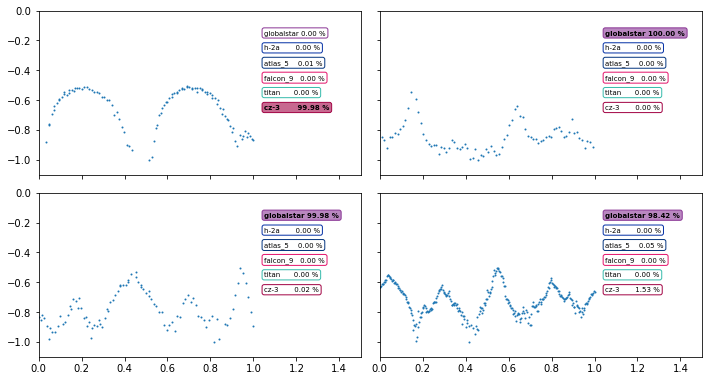

In [40]:
plot_curves2(all_inputs[:4], all_probs[:4], all_labels[:4])

In [ ]:
plt.hist([])